# Objectives
YWBAT
* apply hypothesis testing to a dataset to test for equality of means
* test for the assumptions of various hypothesis tests
* write conclusions for those tests

# Outline
* read in the senateExpenses dataset using pandas
* choose an office to query on
* plot expense distributions by gender
* perform hypothesis testing on payment from those offices by Gender
* drill down into the various types of occupation title for gender and compare expenses

# Disclaimer
This data has not been looked through yet. Your hypotheses tests may not yield anything *interesting*. Nevertheless, it's important to practice hypothesis testing on data. 

In [2]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd

import scipy.stats as scs
from statsmodels.stats.power import TTestIndPower, TTestPower, tt_ind_solve_power

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
def bootstrap(arr):
    return np.random.choice(arr, size=arr.shape, replace=True)


def generate_sample_mus(arr, num_samples=30):
    sample_mus = [] 
    for i in range(num_samples):
        sample = bootstrap(arr)
        mu = np.mean(sample)
        sample_mus.append(mu)
    return sample_mus


def test_for_normality(arr, confidence=0.95):
    t, p = scs.shapiro(arr)
    if p <= 1 - confidence:
        print("reject the null")
        return False
    print("fail to reject the null")
    return True


def cohens_d(arr1, arr2):
    narr1 = len(arr1)
    narr2 = len(arr2)
    dof = narr1 + narr2 - 2
    return (np.mean(arr1) - np.mean(arr2)) / np.sqrt(((narr1-1)*np.std(arr1, ddof=1) ** 2 + (narr2-1)*np.std(arr2, ddof=1) ** 2) / dof)

In [4]:
df = pd.read_excel("../data/senateExpenses")
df.head()

,Unique ID,Last Name,First Name,Middle 1,Middle 2,Middle 3,Full Name,Title,Keyword,Text Cluster,Payment,FULL or Partial,Gender,Office,"Type (office, committee, political staff)",Party,Administrative or Political
0,BLACKBARRYCHAPLAIN,BLACK,BARRY,C,NaN,NaN,BARRY BLACK,CHAPLAIN,CHAPLAIN,NaN,80393.40,Full,M,CHAPLIAIN'S OFFICE,Office,Non-partisan,Administrative
1,BOGOSLAVSKIJODYDIRECTOROFCOMMUNICATIONS,BOGOSLAVSKI,JODY,M,NaN,NaN,JODY BOGOSLAVSKI,DIRECTOR OF COMMUNICATIONS,"DIRECTOR,OF,COMMUNICATIONS",NaN,46999.92,FULL,A,CHAPLIAIN'S OFFICE,Office,Non-partisan,Administrative
2,SCHULTZLISACHIEFOFSTAFF,SCHULTZ,LISA,W,NaN,NaN,LISA SCHULTZ,CHIEF OF STAFF,"CHIEF,OF,STAFF",NaN,61500.00,FULL,F,CHAPLIAIN'S OFFICE,Office,Non-partisan,Administrative
3,CHAPUISSUZANNEEXECUTIVEASSISTANT,CHAPUIS,SUZANNE,M,NaN,NaN,SUZANNE CHAPUIS,EXECUTIVE ASSISTANT,"EXECUTIVE,ASSISTANT",NaN,42000.00,FULL,F,CHAPLIAIN'S OFFICE,Office,Non-partisan,Administrative
4,DEMPSEYERICAPROFESSIONALSTAFFTOMAY.8,DEMPSEY,ERICA,J,NaN,NaN,ERICA DEMPSEY,PROFESSIONAL STAFF TO MAY. 8,"PROFESSIONAL,STAFF,TO,MAY.,8",NaN,6003.77,PARTIAL,F,COMMITTEE ON APPROPRIATIONS,Office,Non-partisan,Administrative


In [5]:
admin_df = df.loc[df['Administrative or Political']=='Administrative']
admin_df.head()

,Unique ID,Last Name,First Name,Middle 1,Middle 2,Middle 3,Full Name,Title,Keyword,Text Cluster,Payment,FULL or Partial,Gender,Office,"Type (office, committee, political staff)",Party,Administrative or Political
0,BLACKBARRYCHAPLAIN,BLACK,BARRY,C,NaN,NaN,BARRY BLACK,CHAPLAIN,CHAPLAIN,NaN,80393.40,Full,M,CHAPLIAIN'S OFFICE,Office,Non-partisan,Administrative
1,BOGOSLAVSKIJODYDIRECTOROFCOMMUNICATIONS,BOGOSLAVSKI,JODY,M,NaN,NaN,JODY BOGOSLAVSKI,DIRECTOR OF COMMUNICATIONS,"DIRECTOR,OF,COMMUNICATIONS",NaN,46999.92,FULL,A,CHAPLIAIN'S OFFICE,Office,Non-partisan,Administrative
2,SCHULTZLISACHIEFOFSTAFF,SCHULTZ,LISA,W,NaN,NaN,LISA SCHULTZ,CHIEF OF STAFF,"CHIEF,OF,STAFF",NaN,61500.00,FULL,F,CHAPLIAIN'S OFFICE,Office,Non-partisan,Administrative
3,CHAPUISSUZANNEEXECUTIVEASSISTANT,CHAPUIS,SUZANNE,M,NaN,NaN,SUZANNE CHAPUIS,EXECUTIVE ASSISTANT,"EXECUTIVE,ASSISTANT",NaN,42000.00,FULL,F,CHAPLIAIN'S OFFICE,Office,Non-partisan,Administrative
4,DEMPSEYERICAPROFESSIONALSTAFFTOMAY.8,DEMPSEY,ERICA,J,NaN,NaN,ERICA DEMPSEY,PROFESSIONAL STAFF TO MAY. 8,"PROFESSIONAL,STAFF,TO,MAY.,8",NaN,6003.77,PARTIAL,F,COMMITTEE ON APPROPRIATIONS,Office,Non-partisan,Administrative


In [6]:
admin_df.shape

(1698, 17)

In [7]:
admin_payment_m = admin_df.loc[admin_df['Gender']=="M", 'Payment']
admin_payment_f = admin_df.loc[admin_df['Gender']=="F", 'Payment']

In [8]:
# plot the payment by gender

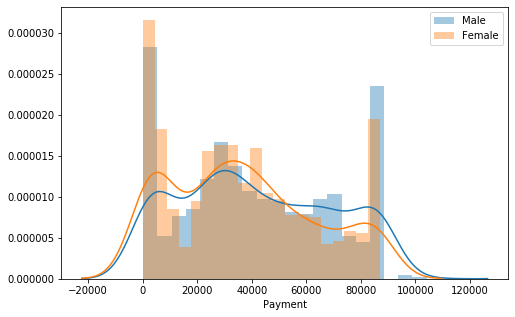

In [9]:
plt.figure(figsize=(8, 5))
sns.distplot(admin_payment_m, label="Male", bins=20)
sns.distplot(admin_payment_f, label="Female", bins=20)
plt.legend()
plt.show()

# Test the payment means by gender using bootstrap sampling to get a normal distribution of mean payments

## What are the assumptions
* Both samples are normal
* Both samples are independent
* Standard deviation is the same
    * we don't need this to be true 
* Data is continuous

H0: mu_M = mu_F

HA: mu_M != mu_F

# What ttest could I use? 
* student ttest (2 sample ind ttest)
    * normality, equal variance
* Welch's ttest (2 sample ind ttest)
    * normality, unequal variance

In [10]:
# test for normality
# H0: data is normal
# HA: data is not normal

t, p = scs.shapiro(admin_payment_m)
print(p)

# p is basically 0 which means we reject the null that the data is Normal

5.765710465363323e-19


In [11]:
# we use the CLT to create a normal distribution of sample means
sample_mus_payments_m = generate_sample_mus(admin_payment_m)
sample_mus_payments_f = generate_sample_mus(admin_payment_f)

In [12]:
test_for_normality(sample_mus_payments_m), test_for_normality(sample_mus_payments_f)

fail to reject the null
reject the null


(True, False)

In [13]:
# run our 2sample_ind_ttest
# H0: mu_M  = mu_F 
# HA: mu_M != mu_F
t, p = scs.ttest_ind(sample_mus_payments_m, sample_mus_payments_f, equal_var=False)
p
# reject the null that the means are the same

3.9875599558345986e-32

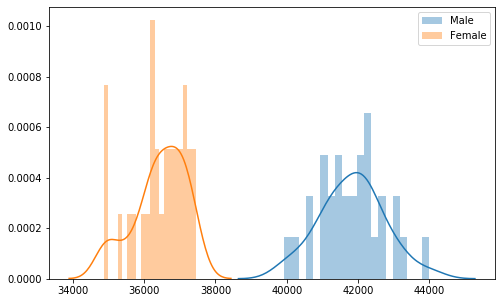

In [14]:
plt.figure(figsize=(8, 5))
sns.distplot(sample_mus_payments_m, label="Male", bins=20)
sns.distplot(sample_mus_payments_f, label="Female", bins=20)
plt.legend()
plt.show()

# what are you conclusions? 
The mean of the sampling distribution of males in this office is different than the mean of the sampling distribution of females. 

# What is the purpose of a Power Test? 
* Ttest - measures: are these different/less/greater, etc
* Power - measures: the probability of correctly rejecting the null given a sample of data, how different

In [15]:
effect_size = cohens_d(sample_mus_payments_m, sample_mus_payments_f)
effect_size

6.517392988108209

In [17]:
power = tt_ind_solve_power(effect_size=effect_size,
                           nobs1=len(sample_mus_payments_m),
                           alpha=0.05)
power

1.0

# Power Analysis
Our power value is 1.0. This means that if given a sample mean we can with almost 100% certainty identify which gender the sample was taken from (males or females).

In [18]:
admin_df['director_chief'] = admin_df['Title'].apply(lambda string: ("director" in string.lower()) or ("chief" in string.lower()))
admin_df.head()

,Unique ID,Last Name,First Name,Middle 1,Middle 2,Middle 3,Full Name,Title,Keyword,Text Cluster,Payment,FULL or Partial,Gender,Office,"Type (office, committee, political staff)",Party,Administrative or Political,director_chief
0,BLACKBARRYCHAPLAIN,BLACK,BARRY,C,NaN,NaN,BARRY BLACK,CHAPLAIN,CHAPLAIN,NaN,80393.40,Full,M,CHAPLIAIN'S OFFICE,Office,Non-partisan,Administrative,False
1,BOGOSLAVSKIJODYDIRECTOROFCOMMUNICATIONS,BOGOSLAVSKI,JODY,M,NaN,NaN,JODY BOGOSLAVSKI,DIRECTOR OF COMMUNICATIONS,"DIRECTOR,OF,COMMUNICATIONS",NaN,46999.92,FULL,A,CHAPLIAIN'S OFFICE,Office,Non-partisan,Administrative,True
2,SCHULTZLISACHIEFOFSTAFF,SCHULTZ,LISA,W,NaN,NaN,LISA SCHULTZ,CHIEF OF STAFF,"CHIEF,OF,STAFF",NaN,61500.00,FULL,F,CHAPLIAIN'S OFFICE,Office,Non-partisan,Administrative,True
3,CHAPUISSUZANNEEXECUTIVEASSISTANT,CHAPUIS,SUZANNE,M,NaN,NaN,SUZANNE CHAPUIS,EXECUTIVE ASSISTANT,"EXECUTIVE,ASSISTANT",NaN,42000.00,FULL,F,CHAPLIAIN'S OFFICE,Office,Non-partisan,Administrative,False
4,DEMPSEYERICAPROFESSIONALSTAFFTOMAY.8,DEMPSEY,ERICA,J,NaN,NaN,ERICA DEMPSEY,PROFESSIONAL STAFF TO MAY. 8,"PROFESSIONAL,STAFF,TO,MAY.,8",NaN,6003.77,PARTIAL,F,COMMITTEE ON APPROPRIATIONS,Office,Non-partisan,Administrative,False


In [10]:
# now lets take into account titles, anything we can do with titles? 

In [11]:
# lets do some feature engineering on titles. add a column called director_chief if the title includes the word director this column should have a value of 1 and a 0 otherwise 

In [12]:
# perform a hypothesis test on director payments